In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

from IPython.display import clear_output

from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
!gdown "1Agtli3q1qy_JwHGuLEWc8H20NM5nDdHY"

Downloading...
From (original): https://drive.google.com/uc?id=1Agtli3q1qy_JwHGuLEWc8H20NM5nDdHY
From (redirected): https://drive.google.com/uc?id=1Agtli3q1qy_JwHGuLEWc8H20NM5nDdHY&confirm=t&uuid=ff7eb452-8bcd-4c73-9273-0ba7de669dbd
To: /content/MVSA-Single.zip
100% 211M/211M [00:06<00:00, 32.7MB/s]


In [ ]:

!unzip MVSA-Single.zip
clear_output()

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
label_map = {
    'positive': 0,
    'negative': 1,
    'neutral': 2
}

In [ ]:
# Get CSV
df = pd.read_csv("MVSA_Single/labelResultAll.csv")

In [ ]:
# Get texts and put in df

path_to_data = "MVSA_Single/data/"
# List to store contents of all txt files
all_captions = []

# List all files in the directory
for file in os.listdir(path_to_data):
  if file.endswith(".txt"):
    # Get the full path of the file
    file_path = os.path.join(path_to_data, file)

    # Open the file and read its content
    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
      content = f.read()

      # Append the content to the list
      all_captions.append(content)

df["text"] = pd.DataFrame({"captions": all_captions})
df["image_path"] = df['image_path'] = df['ID'].apply(lambda x: f"MVSA_Single/data/{x}.jpg")
df['label'] = df['label'].map(label_map)

df.head()

,ID,label,text,image_path
0,1,0,"1 person injured during robbery, shooting in F...",MVSA_Single/data/1.jpg
1,2,0,YOU LOOK SO UGLY! @mypaleskinblog received for...,MVSA_Single/data/2.jpg
2,3,0,RT @DewanMKarim: First @Walmart in 1962 was bu...,MVSA_Single/data/3.jpg
3,4,0,Tom and Christine of #Solares #zero carbon hou...,MVSA_Single/data/4.jpg
4,5,0,Overjoyed!! @maxfrost will return to Portland ...,MVSA_Single/data/5.jpg


In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, texts, images, labels, tokenizer, transform=None):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Text processing
        encoding = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Image processing
        if self.transform:
            image = self.transform(image)

        return {
            'text_input_ids': input_ids,
            'text_attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CombinedModel, self).__init__()
        # Image model
        self.cnn = models.resnet50(pretrained=True)
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()  # Remove the last fully connected layer

        # Text model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_dropout = nn.Dropout(0.3)
        self.bert_linear = nn.Linear(self.bert.config.hidden_size, 256)

        # Combined model
        self.fc = nn.Linear(in_features + 256, num_classes)

    def forward(self, image, input_ids, attention_mask):
        # Image feature extraction
        image_features = self.cnn(image)

        # Text feature extraction
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.bert_dropout(text_output.pooler_output)
        text_features = self.bert_linear(text_features)

        # Combine features
        combined_features = torch.cat((image_features, text_features), dim=1)
        output = self.fc(combined_features)
        return output


In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

labels = df['label'].tolist()
texts = df["text"].to_list()
images = df["image_path"].to_list()

# Split dataset
from sklearn.model_selection import train_test_split

texts_train, texts_test, images_train, images_test, labels_train, labels_test = train_test_split(
    texts, images, labels, test_size=0.2, stratify=labels
)

# Create datasets and dataloaders
train_dataset = MultiModalDataset(texts_train, images_train, labels_train, tokenizer, transform)
test_dataset = MultiModalDataset(texts_test, images_test, labels_test, tokenizer, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['text_input_ids'].to(device)
        attention_mask = batch['text_attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['text_input_ids'].to(device)
            attention_mask = batch['text_attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

# Training loop
for epoch in tqdm(range(10), desc='Epochs'):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    tqdm.write(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

# Evaluation
y_true, y_pred = evaluate_model(model, test_loader)
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epochs:  10%|█         | 1/10 [01:43<15:31, 103.55s/it]

Epoch 1, Loss: 0.9352


Epochs:  20%|██        | 2/10 [03:23<13:32, 101.54s/it]

Epoch 2, Loss: 0.7743


Epochs:  30%|███       | 3/10 [05:03<11:46, 100.94s/it]

Epoch 3, Loss: 0.6446


Epochs:  40%|████      | 4/10 [06:44<10:03, 100.62s/it]

Epoch 4, Loss: 0.4948


Epochs:  50%|█████     | 5/10 [08:23<08:21, 100.36s/it]

Epoch 5, Loss: 0.3401


Epochs:  60%|██████    | 6/10 [10:04<06:41, 100.35s/it]

Epoch 6, Loss: 0.2050


Epochs:  70%|███████   | 7/10 [11:44<05:01, 100.37s/it]

Epoch 7, Loss: 0.1117


Epochs:  80%|████████  | 8/10 [13:24<03:20, 100.35s/it]

Epoch 8, Loss: 0.0699


Epochs:  90%|█████████ | 9/10 [15:05<01:40, 100.36s/it]

Epoch 9, Loss: 0.0456


Epochs: 100%|██████████| 10/10 [16:45<00:00, 100.56s/it]


Epoch 10, Loss: 0.0322
Accuracy: 0.6345


In [ ]:
# After training, save the model's state dictionary
torch.save(model.state_dict(), 'combined_model.pth')

In [ ]:
from google.colab import files

# Download the model state dictionary
files.download('combined_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Summary

Loss: 1.1132
Accuracy: 0.6345
Precision: 0.6275
Recall: 0.6345
F1 Score: 0.6302

Classification Report:

              precision    recall  f1-score   support

    Negative       0.71      0.76      0.74       542
     Neutral       0.53      0.48      0.50       245
    Positive       0.51      0.48      0.49       187

    accuracy                           0.63       974
   macro avg       0.58      0.57      0.58       974
weighted avg       0.63      0.63      0.63       974



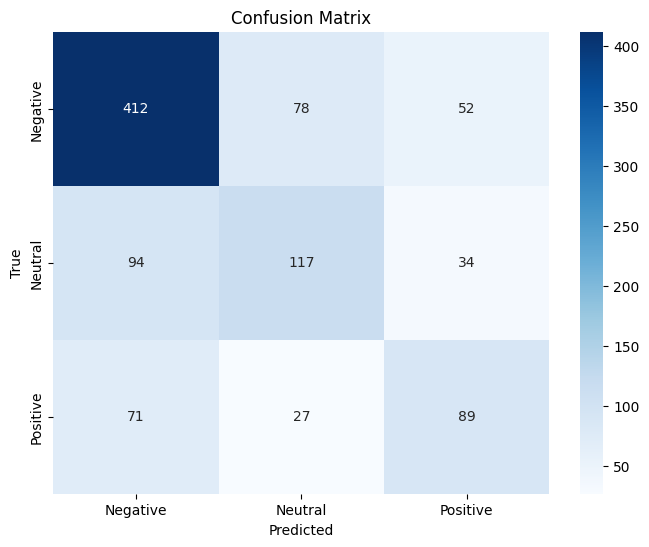

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def generate_summary_report(model, dataloader, criterion, device):
    # Set the model to evaluation mode
    model.eval()

    all_labels = []
    all_predictions = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['text_input_ids'].to(device)
            attention_mask = batch['text_attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            # Collect predictions and labels
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Print classification report
    print(f'Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


generate_summary_report(model, test_loader, criterion, device)
